In [2]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [3]:
iris = datasets.load_iris()
features = iris.data 
target = iris.target

sepal_length = np.array(features[:, 0])
petal_width = np.array(features[:, 3])

species_names = list()

for i in target:
    if i == 0:
        species_names.append('setosa')
    elif i == 1:
        species_names.append('versicolor')
    else:
        species_names.append('virginica')

In [4]:
def predict(intercept, coefficient, dataset):
    return np.array([intercept + coefficient * x for x in dataset])

def create_batches(x, y, batch_size):
    x_batches = np.array_split(x, len(x) // batch_size)
    y_batches = np.array_split(y, len(y) // batch_size)
    return x_batches, y_batches

def mbgd(x, y, epochs, df, batch_size, alpha = 0.01):
    intercept = 2.0
    coefficient = -7.5
    x_batches, y_batches = create_batches(x, y, batch_size)
    
    predictions = predict(intercept, coefficient, x_batches[0])
    sum_error = np.sum((predictions - y_batches[0]) ** 2) / (2 * batch_size)
    df.loc[0] = [-1, intercept, coefficient, sum_error]
    
    index = 1
    for epoch in range(epochs):
        for x, y in zip(x_batches, y_batches):
            sum_error = 0.0
            predictions = predict(intercept, coefficient, x)
            b0_error = (1/batch_size) * np.sum(predictions - y)
            b1_error = (1/batch_size) * np.sum((predictions - y) * x)
            intercept = intercept - alpha * b0_error
            coefficient = coefficient - alpha * b1_error 
            sum_error = sum_error + np.sum((predictions - y) ** 2) / (2 * batch_size)
            df.loc[index] = [int(epoch), intercept, coefficient, sum_error]
            index += 1
    return df

In [5]:
epochs = 5000
mbgd_loss = pd.DataFrame(columns=['epoch', 'intercept', 'coefficient', 'sum_error'])
mbgd_loss = mbgd(sepal_length, petal_width, epochs = epochs, batch_size=64, df = mbgd_loss)
mbgd_loss['epoch'] = mbgd_loss['epoch'].astype(int)

total = len(mbgd_loss) - 1
half = int(epochs / 2) - 1
quarter = int(epochs / 4) - 1

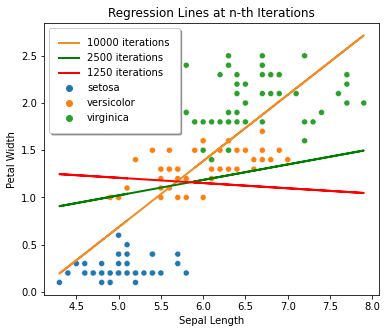

In [6]:
plt.figure(figsize=(6,5))

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    hue = species_names
)

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][total] + mbgd_loss['coefficient'][total] * sepal_length,
    '#f28c28',
    linewidth = 2,
    label = f'{total} iterations'
)

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][half] + mbgd_loss['coefficient'][half] * sepal_length,
    '-g',
    linewidth = 2,
    label = f'{half + 1} iterations'
)

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][quarter] + mbgd_loss['coefficient'][quarter] * sepal_length,
    '-r',
    linewidth = 2,
    label = f'{quarter + 1} iterations'
)

plt.title("Regression Lines at n-th Iterations")
plt.xlabel("Sepal Length")
plt.ylabel("Petal Width")

plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

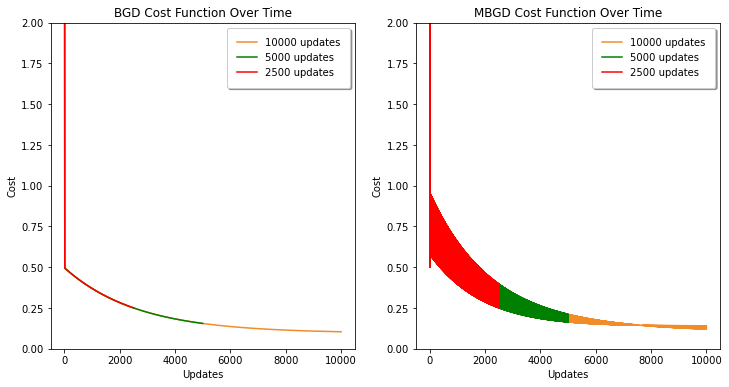

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

bgd_loss = pd.read_csv("./csv/bgd_loss.csv")
x = 10000
half_x = int(x / 2) - 1
quarter_x = int(x / 4) - 1
ax[0].plot(np.arange(0, x - 1), bgd_loss['sum_error'][:x - 1], color = '#f28c28', label = f'{x} updates')
ax[0].plot(np.arange(0, half_x), bgd_loss['sum_error'][:half_x], color = 'green', label = f'{half_x + 1} updates')
ax[0].plot(np.arange(0, quarter_x), bgd_loss['sum_error'][:quarter_x], color = 'red', label = f'{quarter_x + 1} updates')
ax[0].set_title(f'BGD Cost Function Over Time')
ax[0].set_ylim(0, 2.0)
ax[0].set_xlabel("Updates")
ax[0].set_ylabel("Cost")
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

ax[1].plot(np.arange(0, x-1), mbgd_loss['sum_error'][:x-1], color = '#f28c28', label = f'{x} updates')
ax[1].plot(np.arange(0, half_x), mbgd_loss['sum_error'][:half_x], color = 'green', label = f'{half_x + 1} updates')
ax[1].plot(np.arange(0, quarter_x), mbgd_loss['sum_error'][:quarter_x], color = 'red', label = f'{quarter_x + 1} updates')
ax[1].set_title(f'MBGD Cost Function Over Time')
ax[1].set_ylim(0, 2.0)
ax[1].set_xlabel("Updates")
ax[1].set_ylabel("Cost")
ax[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

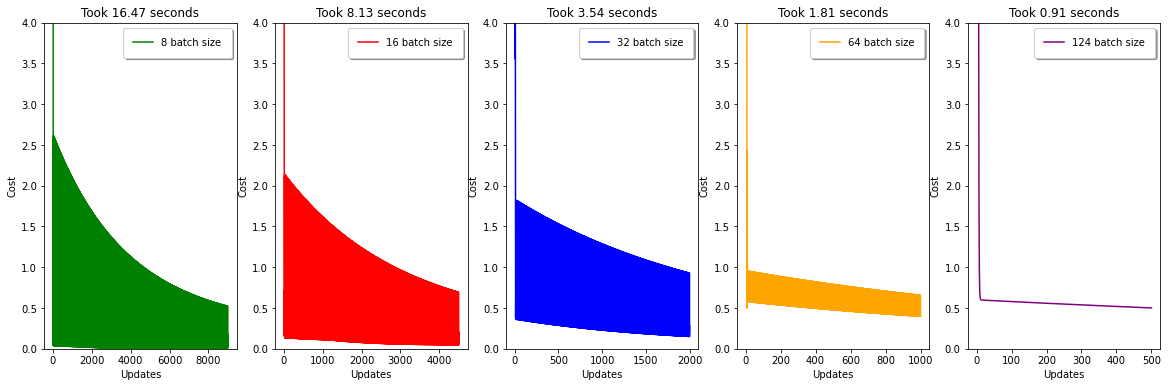

In [16]:
import time
fig, ax = plt.subplots(1, 5, figsize=(20, 6))

batch_sizes = [8, 16, 32, 64, 124]
colors = ['green', 'red', 'blue', 'orange', 'purple']

i=0
for size, color in zip(batch_sizes, colors):
    loss = pd.DataFrame(columns=['epoch', 'intercept', 'coefficient', 'sum_error'])
    start = time.time()
    loss = mbgd(sepal_length, petal_width, epochs = 500, batch_size=size, df = loss)
    end = time.time()
    loss['epoch'] = loss['epoch'].astype(int)

    length = len(loss)

    ax[i].plot(np.arange(0, length), loss['sum_error'][:length], color = color, label = f'{size} batch size')
    ax[i].set_title(f'Took {end - start:.2f} seconds')
    ax[i].set_ylim(0, 4.0)
    ax[i].set_xlabel("Updates")
    ax[i].set_ylabel("Cost")
    ax[i].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    i += 1

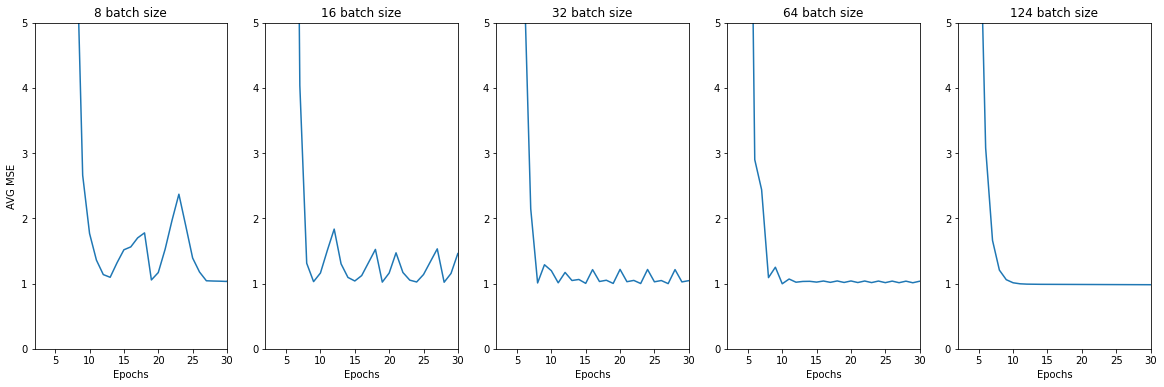

In [20]:
fig, ax = plt.subplots(1, 5, figsize=(20, 6))

batch_sizes = [8, 16, 32, 64, 124]
colors = ['green', 'red', 'blue', 'orange', 'purple']
y_true = petal_width
position = 0

for size, color in zip(batch_sizes, colors):
    loss = pd.DataFrame(columns=['epoch', 'intercept', 'coefficient', 'sum_error'])
    loss = mbgd(sepal_length, petal_width, epochs = 500, batch_size=size, df = loss)

    y_pred = list()
    for intercept, coefficient in zip(loss['intercept'], loss['coefficient']):
        y_pred.append(intercept + coefficient * sepal_length)

    mse = list()
    for i in y_pred:
        mse.append(np.mean((i - y_true) ** 2))

    ax[position].plot(mse)
    ax[position].set_ylim(0, 5)
    ax[position].set_xlim(2, 30)
    ax[position].set_title(f'{size} batch size')
    if position == 0:
        ax[position].set_ylabel('AVG MSE')
    ax[position].set_xlabel('Epochs')
    position += 1

(4.2, 8.0)

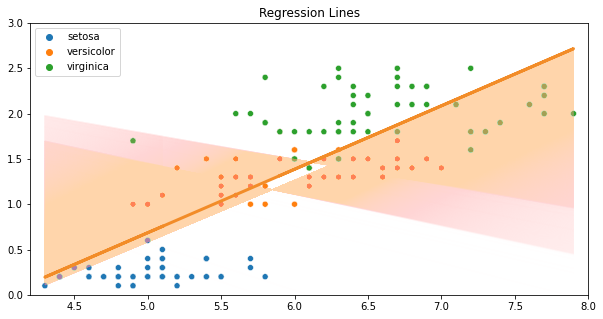

In [10]:
plt.figure(figsize=(10,5))

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    hue = species_names
)

length = len(mbgd_loss) - 1

for i in range(0, length):
    # plot the regression line
    plt.plot(
        sepal_length, 
        mbgd_loss['intercept'][i] + mbgd_loss['coefficient'][i] * sepal_length,
        color = '#ffd5ab',
        linestyle = '-',
        lw = 1,
        alpha = 0.01
    )

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][length] + mbgd_loss['coefficient'][length] * sepal_length,
    color = '#f28c28',
    lw = 3,
    linestyle = '-'
)

plt.title("Regression Lines")
plt.ylim(0.0, max(petal_width) + 0.5)
plt.xlim(min(sepal_length) - 0.1, max(sepal_length) + 0.1)

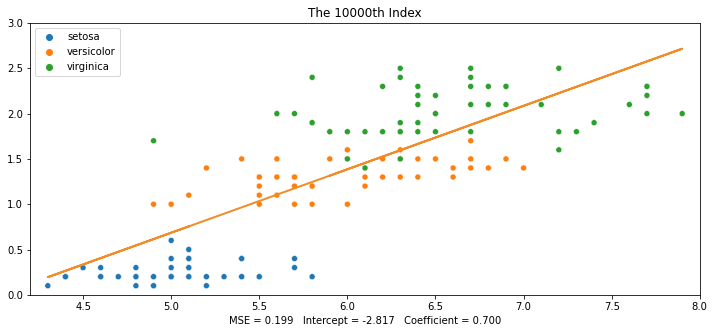

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
plt.xlim(min(sepal_length) - 0.1, max(sepal_length) + 0.1)
plt.ylim(0, max(petal_width) + 0.5)

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    hue = species_names
)

line, = ax.plot(
    sepal_length, 
    mbgd_loss['intercept'][0] + mbgd_loss['coefficient'][0] * sepal_length,
    color="#f28c28", 
    linestyle='-',
    linewidth = 2, 
    label = 'regression line'
)

def update(frame_num):
    regline = mbgd_loss['intercept'].loc[frame_num] + mbgd_loss['coefficient'].loc[frame_num] * sepal_length
    line.set_ydata(regline)
    plt.title(f"The {frame_num}th Index")
    plt.xlabel(f"MSE = {mean_squared_error(regline, petal_width):.3f}   Intercept = {mbgd_loss['intercept'].loc[frame_num]:.3f}   Coefficient = {mbgd_loss['coefficient'].loc[frame_num]:.3f}")
    return line, ax

anim = FuncAnimation(fig, update, repeat = True, frames=np.arange(0, len(mbgd_loss), 50), interval=10)
anim.save(
    './gif/mbgd.gif', 
    writer = PillowWriter(fps=60), 
    dpi = 150
)
plt.show()

In [12]:
# generate a mean squared error contour surface
intercepts = np.linspace(-10, 10, 10)
coefficients = np.linspace(-10, 10, 10)
x, y = np.meshgrid(intercepts, coefficients)
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = mean_squared_error(predict(x[i, j], y[i, j], sepal_length), petal_width)

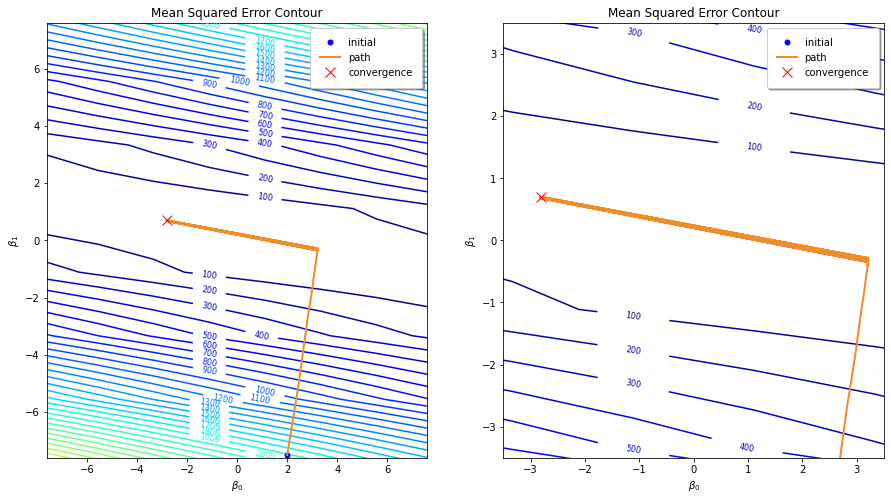

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
contours = ax[0].contour(x, y, z, 50, cmap = 'jet')
ax[0].clabel(contours, inline = True, fontsize = 8)
ax[0].set_title("Mean Squared Error Contour")
ax[0].plot(mbgd_loss['intercept'][0], mbgd_loss['coefficient'][0], "o", markersize=5, color="blue", label="initial")
ax[0].plot(mbgd_loss['intercept'][0:len(mbgd_loss)-2], mbgd_loss['coefficient'][0:len(mbgd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[0].plot(mbgd_loss['intercept'][len(mbgd_loss)-1], mbgd_loss['coefficient'][len(mbgd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[0].set_xlim(-7.6, 7.6)
ax[0].set_ylim(-7.6, 7.6)
ax[0].set_xlabel(r'$\beta_0$')
ax[0].set_ylabel(r'$\beta_1$')
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

contours = ax[1].contour(x, y, z, 50, cmap = 'jet')
ax[1].clabel(contours, inline = True, fontsize = 8)
ax[1].set_title("Mean Squared Error Contour")
ax[1].plot(mbgd_loss['intercept'][0], mbgd_loss['coefficient'][0], "o", markersize=5, color="blue", label="initial")
ax[1].plot(mbgd_loss['intercept'][0:len(mbgd_loss)-2], mbgd_loss['coefficient'][0:len(mbgd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[1].plot(mbgd_loss['intercept'][len(mbgd_loss)-1], mbgd_loss['coefficient'][len(mbgd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[1].set_xlim(-3.5, 3.5)
ax[1].set_ylim(-3.5, 3.5)
ax[1].set_xlabel(r'$\beta_0$')
ax[1].set_ylabel(r'$\beta_1$')
ax[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

In [ ]:
# save mbgd_loss to csv
mbgd_loss.to_csv('./csv/mbgd_loss.csv')